In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from energyflow.archs import EFN
from energyflow.utils import data_split

2023-10-11 16:12:20.093740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def read_data(file_path):
    data_file = open(file_path)
    lno = 0
    pTvals = []
    etavals = []
    phivals = []
    tvals = []
    events_input=[]
    events_target=[]
    data = []

    for line in data_file:
        lno+=1
        if (lno > 1000000000):
            break
        # enumber = int(line.split()[0])
        isprime = int(line.split()[1])
        E = float(line.split()[2])
        px = float(line.split()[3])
        py = float(line.split()[4])
        pz = float(line.split()[5])
        t = float(line.split()[6])
        
        pT = math.sqrt( px**2 + py**2 )
        p = math.sqrt( px**2 + py**2 + pz**2 )
        
        if (pz > 0):    
            eta = math.acosh(p / pT)
        else:
            eta = -math.acosh(p / pT)
        phi = math.atan( py / px )
        
        if (isprime==1):
            pTvals += [pT]
            etavals += [eta]
            phivals += [phi]
            tvals += [t]
            data += [[pT,eta,phi,t]]
        if (isprime==0):
            events_target += [[t]] 
            if (lno > 1):
                events_input += [data]
            data=[]

    events_input += [data]

    return events_input, events_target



In [3]:
def zero_padding(raw_data, max_num):

    input_zp = np.zeros([max_num,40,4])

    for i in range(0, max_num):
        for j in range(min(40,len(raw_data[i]))):
            input_zp[i,j,:] = raw_data[i][j]
        # np.random.shuffle(input_zp[i,:,:])

    return input_zp

In [4]:
def normalization(input, target, max_num, factor):

    pT_weighted_time = []   
    
    for jet in input:
        mask = jet[:,0] > 0
        yphi_avg = np.average(jet[mask,1:3], weights=jet[mask,0], axis=0)
        jet[mask,1:3] -= yphi_avg
        
        t_avg = np.average(jet[mask,3], weights=jet[mask,0], axis=0)
        pT_weighted_time += [[t_avg]]

        jet[mask,3] *= factor
        # jet[mask,3] /= t_avg
        # jet[mask,3] -= 1
        jet[mask,0] /= jet[:,0].sum()

    target = np.array(target[:max_num])
    target_scaled = target * factor

    return pT_weighted_time, input, target_scaled

In [5]:
def preprocessing(input_path_list, max_num):

    data_input_dict = {}
    data_label_dict = {}
    data_rtd_dict = {}
    factor = 0
    for key, data_path in enumerate(input_path_list):
        
        raw_input, raw_label = read_data(data_path)
        input_zp = zero_padding(raw_input, max_num)

        # if ( 1e-10 < raw_input[0][0][3]) and (raw_input[0][0][3]< 1e-9 ):
        #     factor = 1e9
        # elif ( 1e-9 < raw_input[0][0][3]) and ( raw_input[0][0][3]< 1e-8 ):
        #     factor = 1e8
        # elif ( 1e-8 < raw_input[0][0][3]) and ( raw_input[0][0][3]< 1e-7 ):
        #     factor = 1e7
        factor = 1e8
            
        pTweighted_time, input_scaled, label_scaled = normalization(input_zp, raw_label, max_num, factor)

        data_input_dict["input"+data_path] = input_scaled
        data_label_dict["label"+data_path] = label_scaled
        data_rtd_dict["rtd"+data_path] = (np.array(pTweighted_time) / np.array(raw_label[:max_num])) -1

    return data_rtd_dict, data_input_dict, data_label_dict

In [6]:
def mixture(input_dict, label_dict, train_fraction):

    mixed_input = []
    mixed_label = []
    individual_input_list = []
    individual_label_list = []

    for input_config in input_dict.values():
        
        train_len = int(len(input_config) * train_fraction)
        if (len(mixed_input) != 0):
            mixed_input = np.concatenate((mixed_input, input_config[0:train_len]), axis=0)
            # train_len = 0
        else:
            mixed_input = input_config[0:train_len]

        individual_input_list.append(input_config[train_len:])
            

    for label_config in label_dict.values():

        train_len = int(len(label_config) * train_fraction) 
        if (len(mixed_label) != 0):
            mixed_label = np.concatenate((mixed_label, label_config[0:train_len]), axis=0)
        else:
            mixed_label = label_config[0:train_len]

        individual_label_list.append(label_config[train_len:])
            
         
    return mixed_input, mixed_label, individual_input_list, individual_label_list

In [7]:
input_path_list = []


eta_J = -20
x_t = 500
for eta_M in range (-30, 35, 5):
    file_path = f"/root/jettiming/ScriptForDecaying/fixed_etaJ_{eta_J}_xt_{x_t}/clustered_etaM_{eta_M}_etaJ_{eta_J}_xt_{x_t}/processed_delayed_jet"
    input_path_list.append(file_path)
    
train_fraction = 1

In [8]:
print(input_path_list)

['/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_-30_etaJ_-20_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_-25_etaJ_-20_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_-20_etaJ_-20_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_-15_etaJ_-20_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_-10_etaJ_-20_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_-5_etaJ_-20_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_0_etaJ_-20_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_5_etaJ_-20_xt_500/processed_delayed_jet', '/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_10_e

In [9]:
num_jets = 20000

rtd_dict, input_dict, label_dict = preprocessing(input_path_list, num_jets)

In [10]:
for key in list(input_dict.keys()):
    print(f"{key}:{len(input_dict[key])}")

input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_-30_etaJ_-20_xt_500/processed_delayed_jet:20000
input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_-25_etaJ_-20_xt_500/processed_delayed_jet:20000
input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_-20_etaJ_-20_xt_500/processed_delayed_jet:20000
input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_-15_etaJ_-20_xt_500/processed_delayed_jet:20000
input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_-10_etaJ_-20_xt_500/processed_delayed_jet:20000
input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_-5_etaJ_-20_xt_500/processed_delayed_jet:20000
input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_0_etaJ_-20_xt_500/processed_delayed_jet:20000
input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/clustered_etaM_5_etaJ_-20_xt_500/processed_delayed_jet:20000
input/root/je

In [11]:
mixed_input, mixed_label, test_input_list, test_label_list = mixture(input_dict, label_dict, train_fraction)

In [12]:
print(mixed_input[0])
print(mixed_label[0])

[[ 1.98651225e-01  3.69872917e-03 -8.50737679e-03  4.96263556e+00]
 [ 1.20029150e-01  1.06316920e-03 -1.30580288e-02  4.96839214e+00]
 [ 1.17467818e-01  7.00087508e-03 -2.88316551e-03  4.95545333e+00]
 [ 1.09183843e-01 -9.37241117e-03 -2.60636381e-02  4.99137534e+00]
 [ 9.81772995e-02 -2.39889057e-02  7.24544483e-03  5.02396284e+00]
 [ 5.98490073e-02  4.34038519e-02  7.29966813e-02  4.87866829e+00]
 [ 4.81934679e-02  1.88364540e-02 -3.64034016e-02  4.93010503e+00]
 [ 4.26039887e-02 -9.66809147e-03  4.85709883e-03  4.99196713e+00]
 [ 3.83692551e-02 -1.54264925e-01 -2.36526633e-01  5.34265602e+00]
 [ 2.80308244e-02  8.28096951e-03 -8.18738780e-02  4.95308891e+00]
 [ 2.52916548e-02  2.12934722e-02  8.78501190e-03  4.92475521e+00]
 [ 1.54725569e-02  1.23604101e-01  8.54175427e-02  4.72413456e+00]
 [ 1.40216296e-02  1.19574954e-01  1.20842090e-01  4.73182597e+00]
 [ 1.19319650e-02 -3.53961733e-02  4.05010710e-01  5.05599541e+00]
 [ 9.92764940e-03 -3.30348720e-02  3.87780724e-02  5.04449398e

In [13]:
train = int(0.79*len(mixed_input))
val = int(0.2*len(mixed_input))
test = len(mixed_input) - train - val


# Split the mixed data. The shuffle take place before splitting.
(z_train, z_val, z_test,
 X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(mixed_input[:,:,0], mixed_input[:,:,1:], mixed_label, 
 val=val, test=test, shuffle = True)

In [14]:
Phi_sizes, F_sizes = (200, 200, 200), (200, 200, 200)
output_act = 'linear'
loss = 'mse'

In [15]:
from tensorflow import keras
opt = keras.optimizers.Adam(learning_rate=0.00001)

In [16]:
mixed_efn = EFN(input_dim=3, Phi_sizes=Phi_sizes, F_sizes=F_sizes,
         output_act=output_act, output_dim=1, loss=loss, metrics=[], optimizer = opt)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phats_input (InputLayer)       [(None, None, 3)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 200)    800         ['phats_input[0][0]']            
                                                                                                  
 activation (Activation)        (None, None, 200)    0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 200)    40200       ['activation[0][0]']             
                                                                                              

2023-10-11 16:13:25.138390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 16:13:25.140481: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [17]:
num_epoch = 200
batch_size = 400

hist =  mixed_efn.fit([z_train, X_train], Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=([z_val, X_val], Y_val),
        verbose=1,shuffle = True)

Epoch 1/200
514/514 [==============================] - 148s 286ms/step - loss: 0.9379 - val_loss: 3.0301e-04
Epoch 2/200
514/514 [==============================] - 151s 294ms/step - loss: 2.9461e-04 - val_loss: 2.5197e-04
Epoch 3/200
514/514 [==============================] - 154s 300ms/step - loss: 2.5626e-04 - val_loss: 2.2311e-04
Epoch 4/200
514/514 [==============================] - 152s 296ms/step - loss: 2.2450e-04 - val_loss: 1.8827e-04
Epoch 5/200
514/514 [==============================] - 140s 273ms/step - loss: 1.9123e-04 - val_loss: 1.6196e-04
Epoch 6/200
514/514 [==============================] - 148s 288ms/step - loss: 1.7437e-04 - val_loss: 1.5086e-04
Epoch 7/200
514/514 [==============================] - 144s 281ms/step - loss: 1.6609e-04 - val_loss: 1.5091e-04
Epoch 8/200
514/514 [==============================] - 145s 282ms/step - loss: 1.6183e-04 - val_loss: 1.4391e-04
Epoch 9/200
514/514 [==============================] - 150s 292ms/step - loss: 1.5832e-04 - val_loss

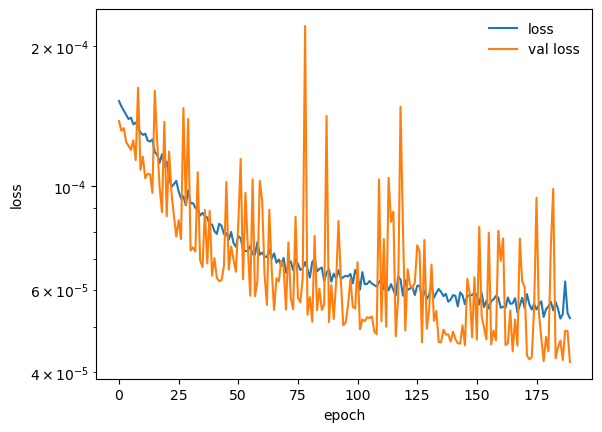

In [18]:
plt.plot(hist.history['loss'][10:],label="loss")
plt.plot(hist.history['val_loss'][10:],label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale('log')
plt.legend(frameon=False)

In [19]:
import tensorflow as tf

mixed_efn.save('org_unnor_var_etaM_3.h5')

In [20]:
unseenetaM_path_list = []

for test_etaM in range(-30, 31, 1):

    unseenetaM_path = f'/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/testdata/test_clustered_etaM_{test_etaM}_etaJ_{eta_J}_xt_{x_t}/processed_delayed_jet'
    unseenetaM_path_list.append(unseenetaM_path)

In [21]:
num_test = 4000
unseen_rtd_dict, unseen_input_dict, unseen_label_dict = preprocessing(unseenetaM_path_list, num_test)

In [22]:
unseen_input_keylist = list(unseen_input_dict.keys())
print(unseen_input_keylist)

['input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/testdata/test_clustered_etaM_-30_etaJ_-20_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/testdata/test_clustered_etaM_-29_etaJ_-20_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/testdata/test_clustered_etaM_-28_etaJ_-20_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/testdata/test_clustered_etaM_-27_etaJ_-20_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/testdata/test_clustered_etaM_-26_etaJ_-20_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/testdata/test_clustered_etaM_-25_etaJ_-20_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20_xt_500/testdata/test_clustered_etaM_-24_etaJ_-20_xt_500/processed_delayed_jet', 'input/root/jettiming/ScriptForDecaying/fixed_etaJ_-20

 1/20 [>.............................] - ETA: 0s

/tmp/ipykernel_2350365/237986340.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


20/20 [==============================] - 1s 28ms/step


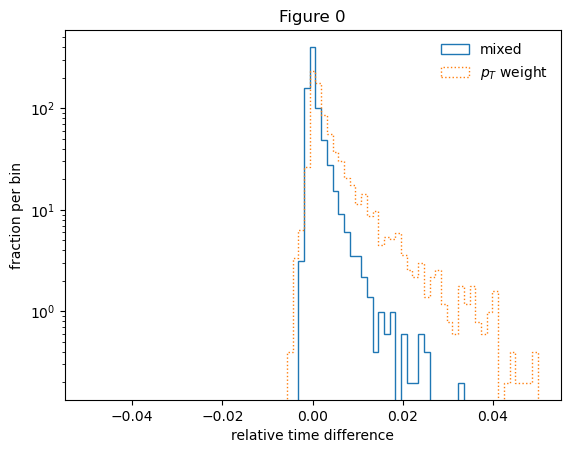

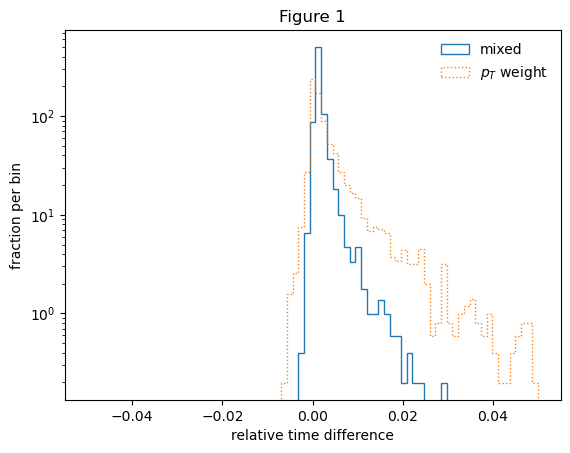

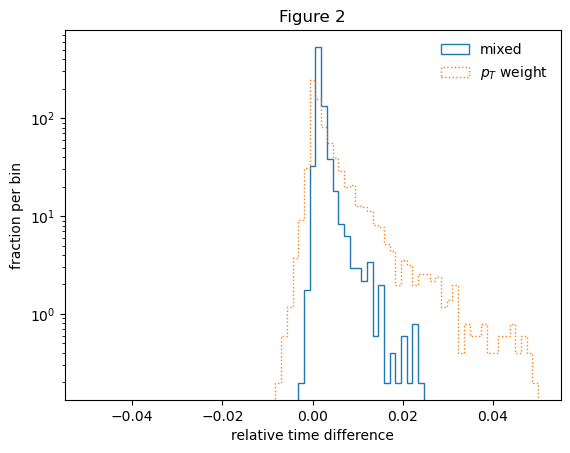

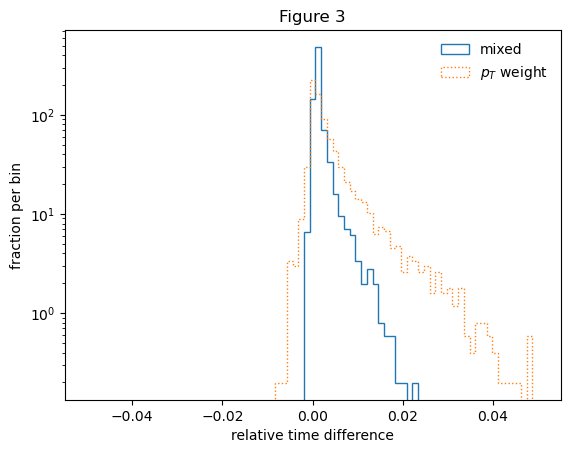

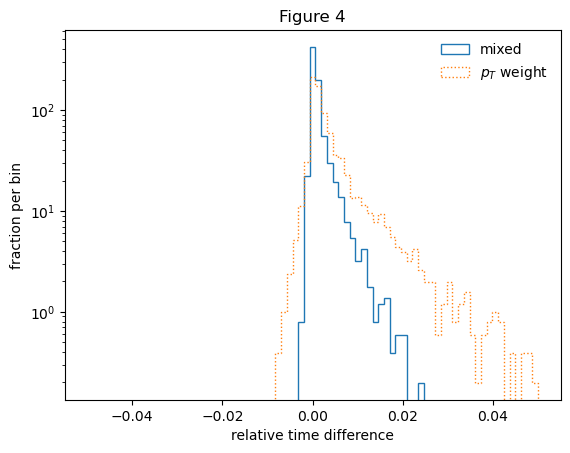

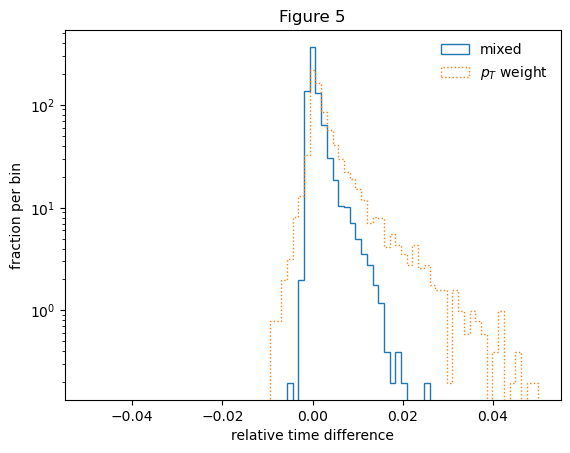

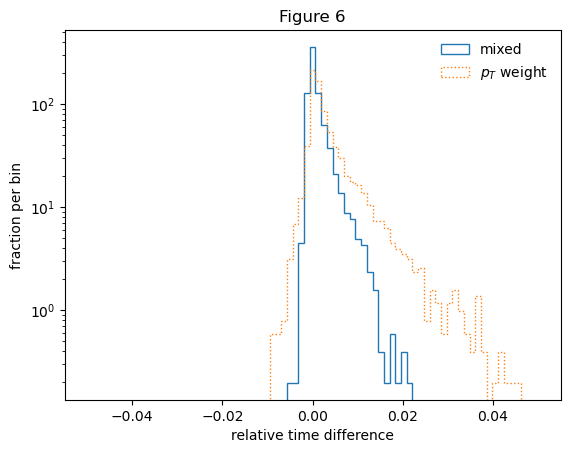

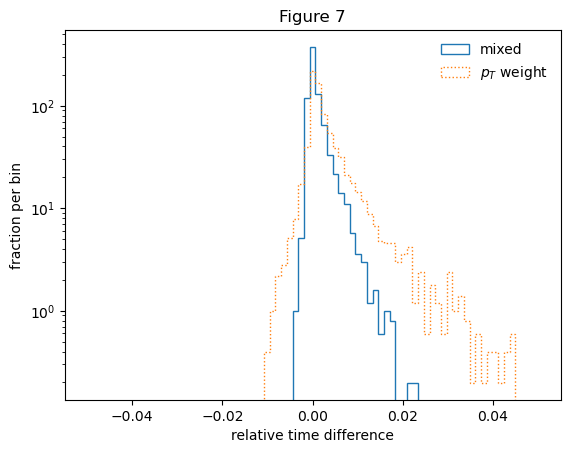

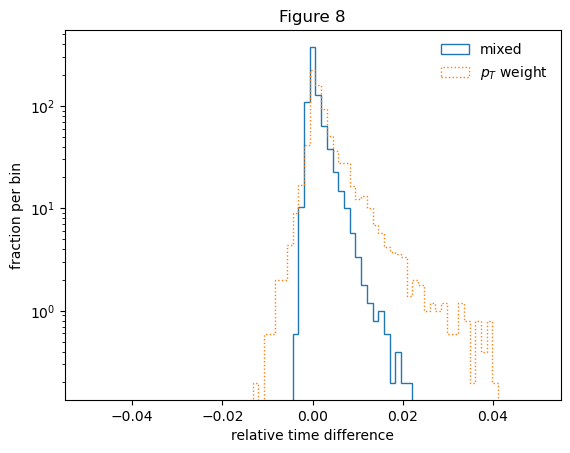

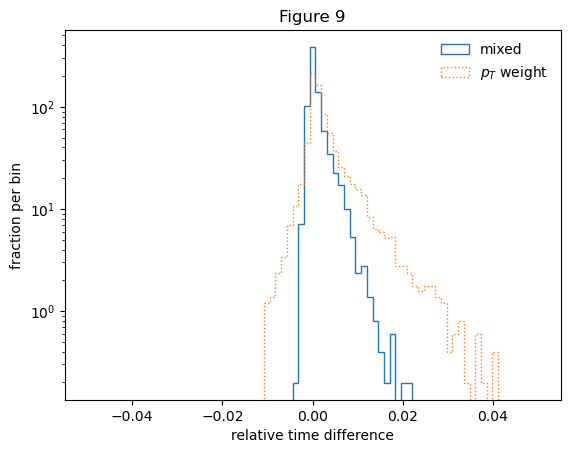

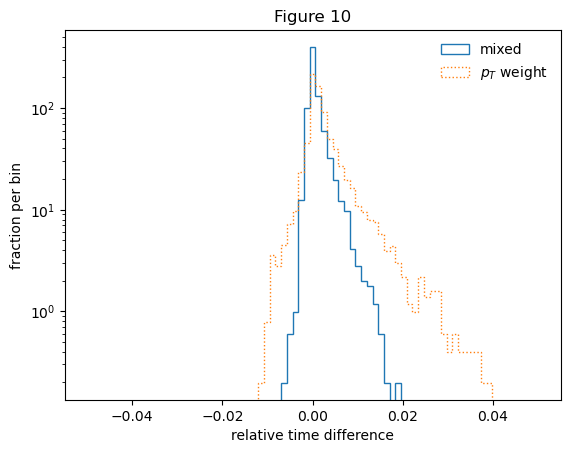

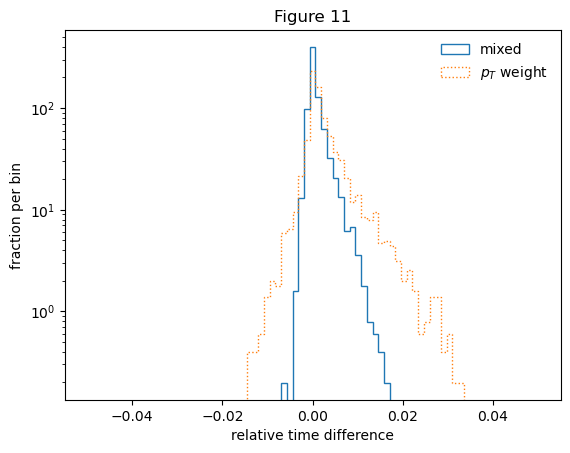

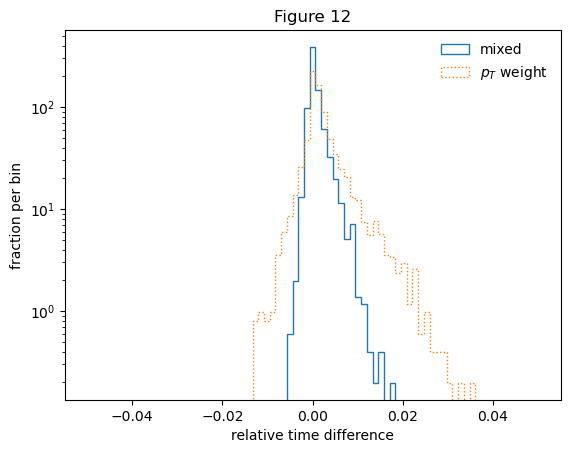

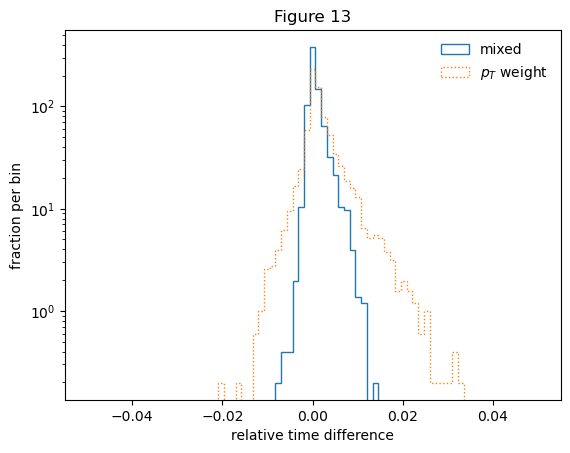

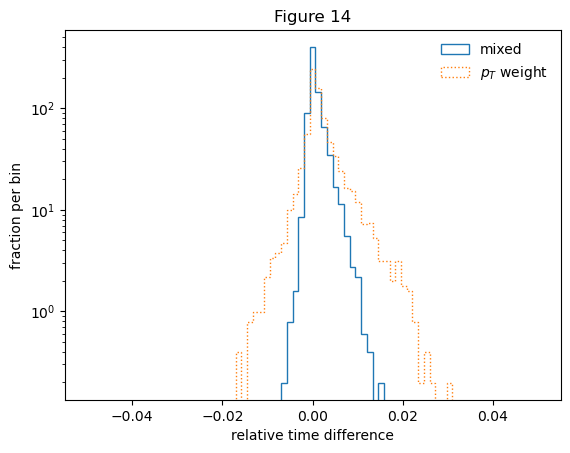

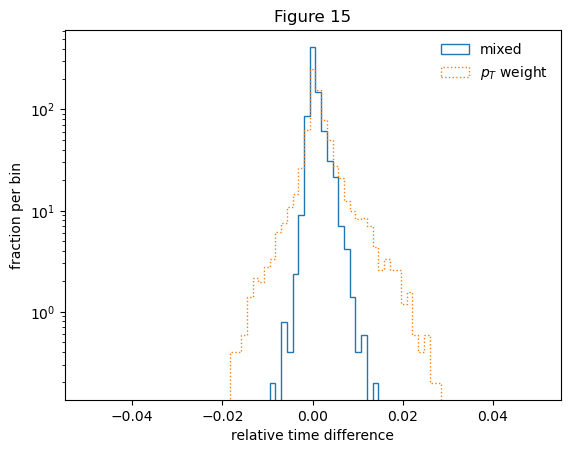

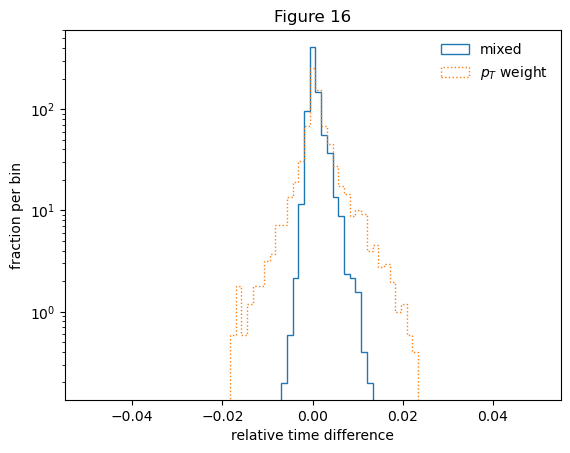

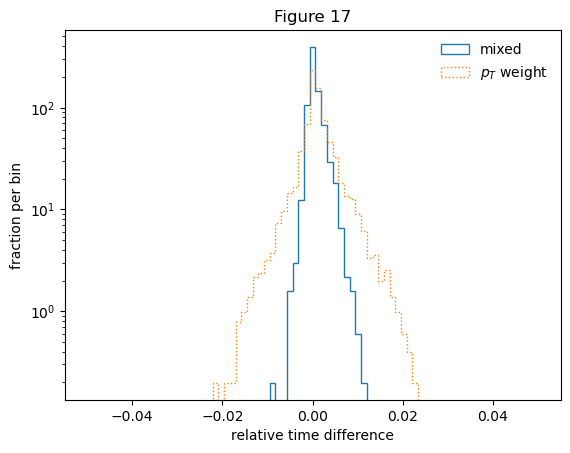

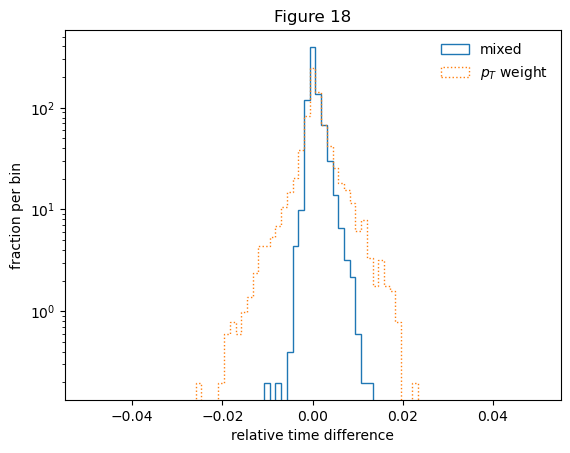

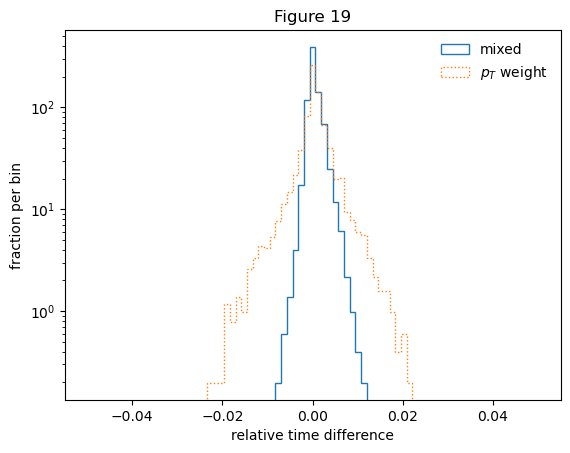

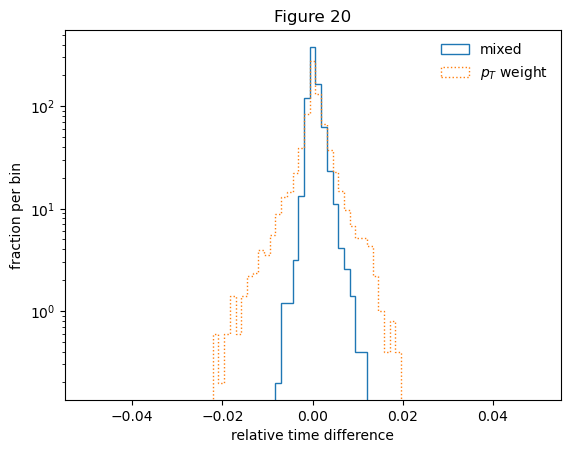

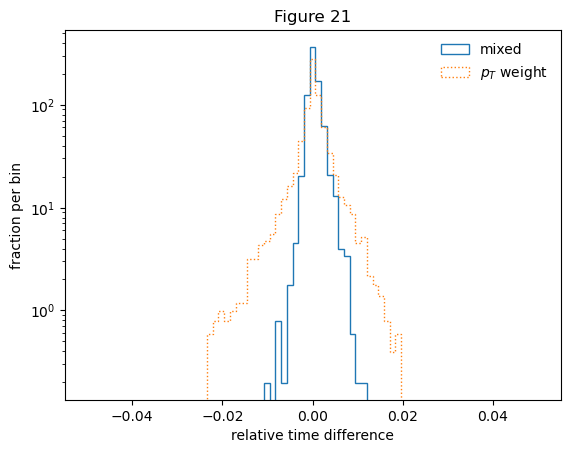

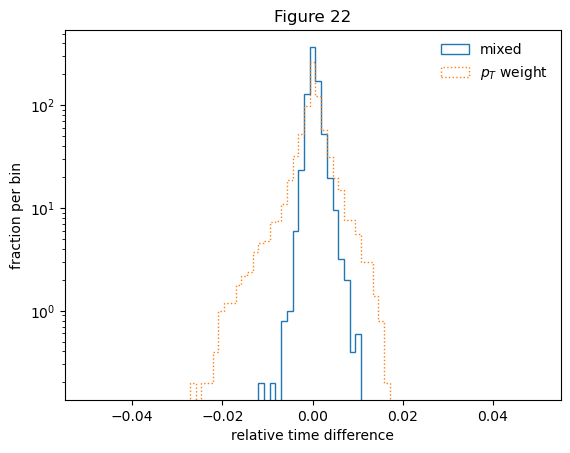

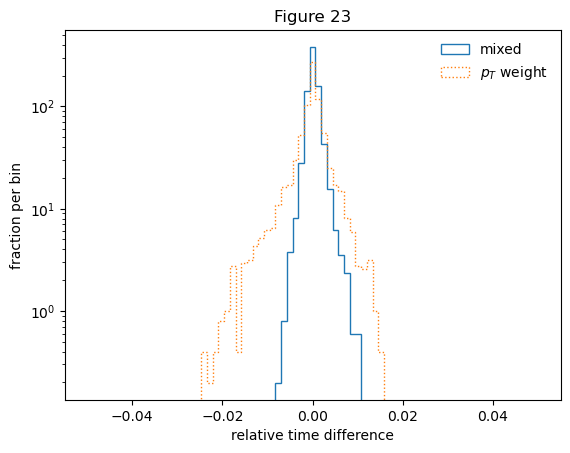

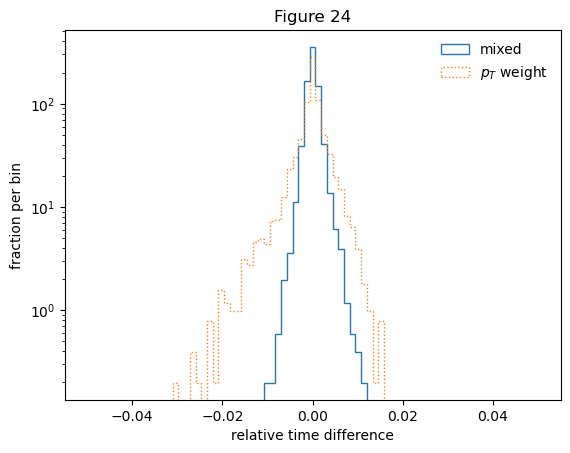

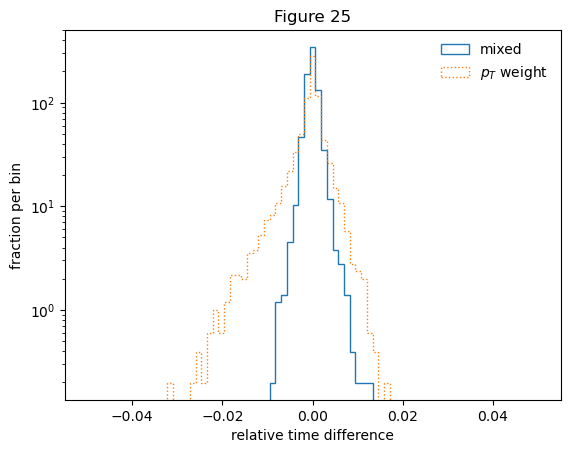

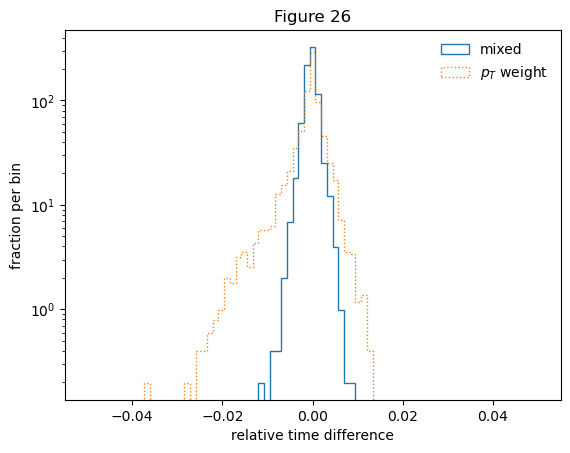

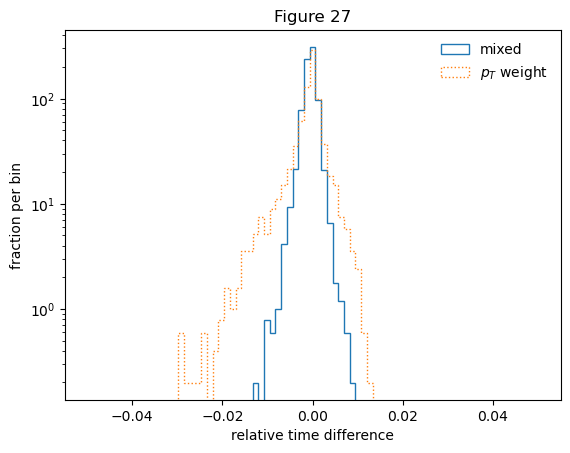

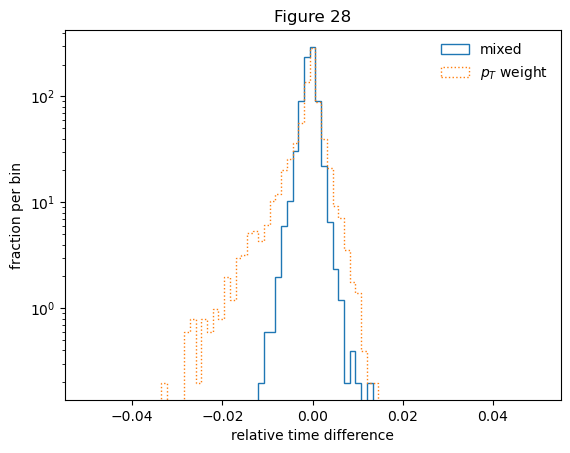

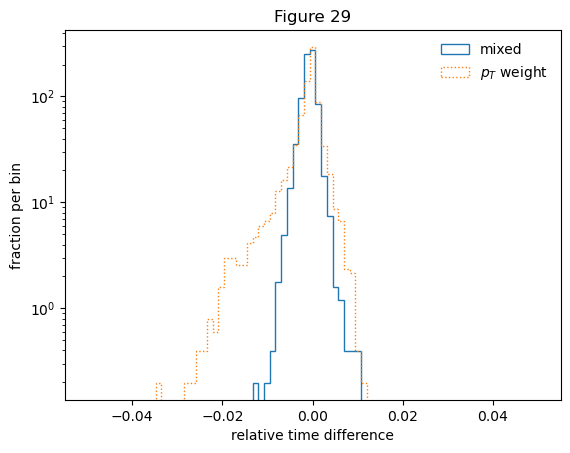

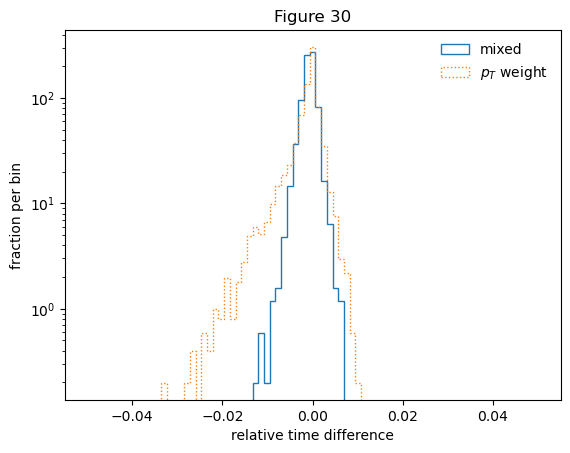

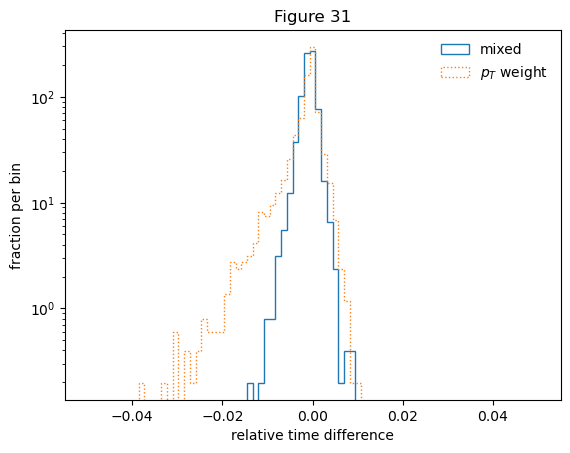

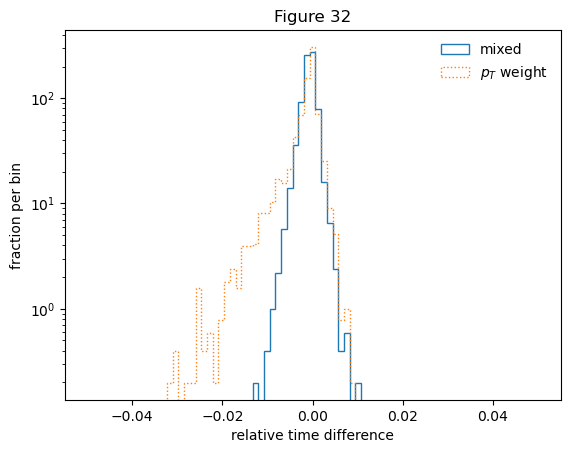

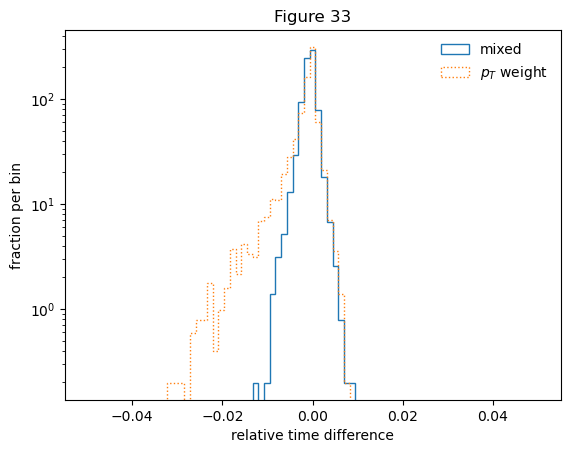

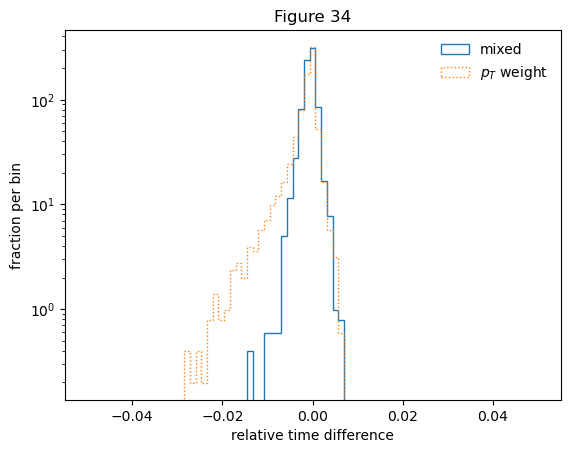

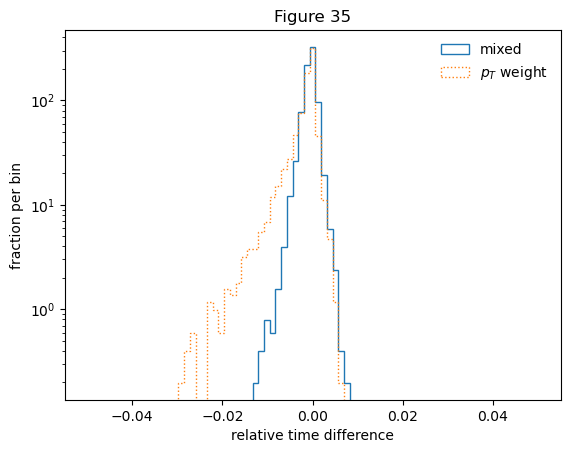

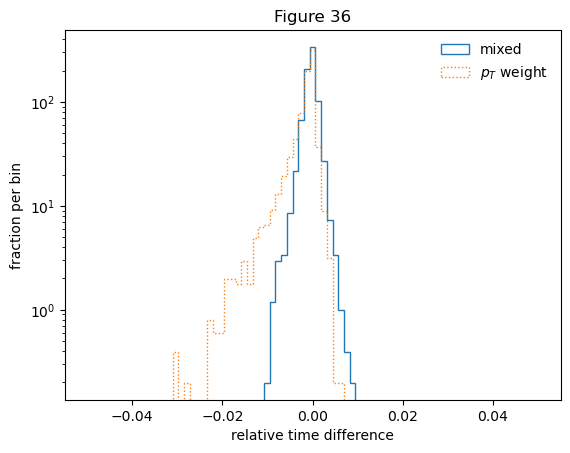

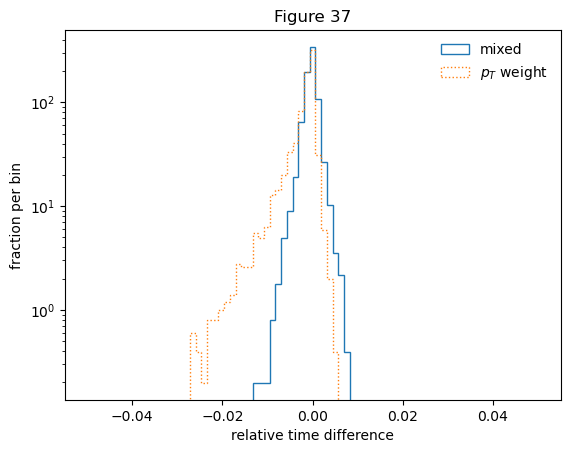

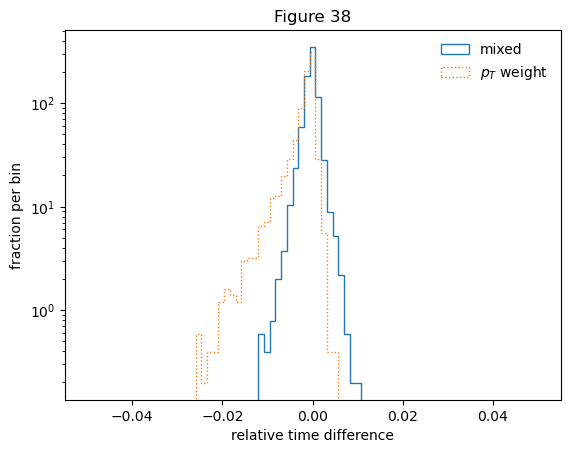

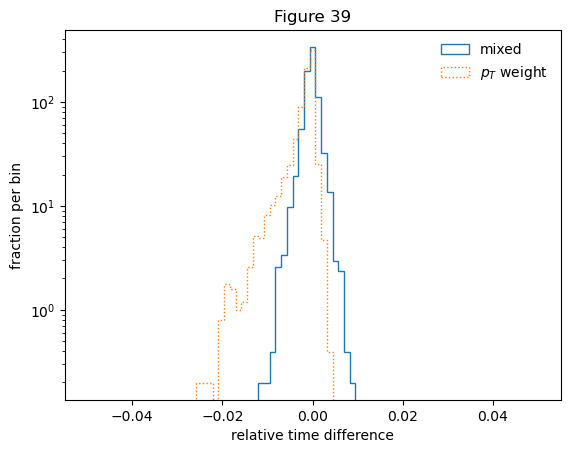

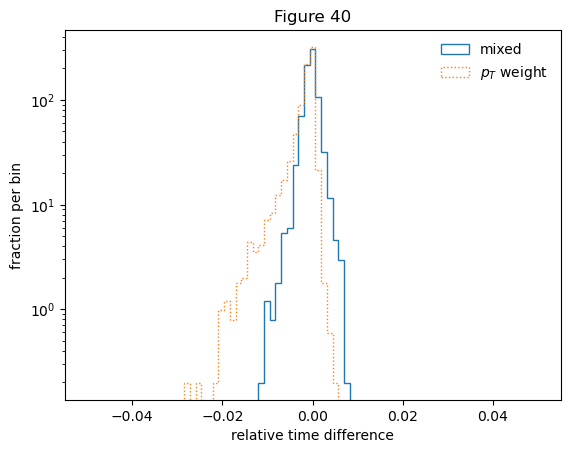

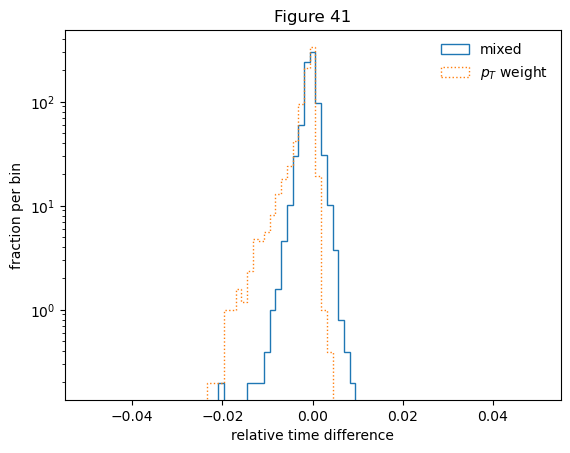

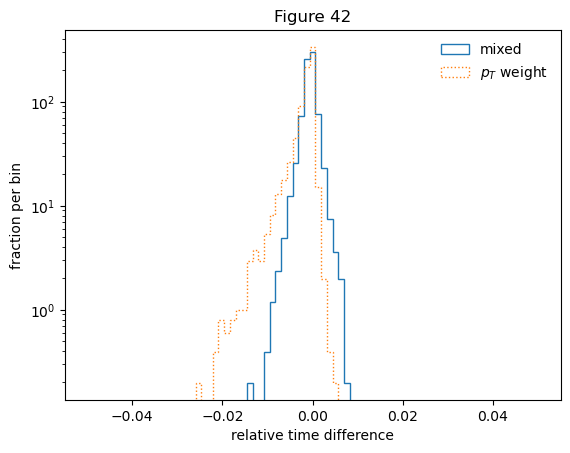

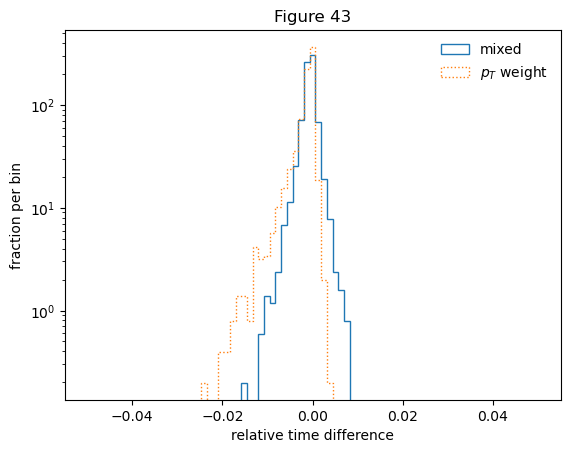

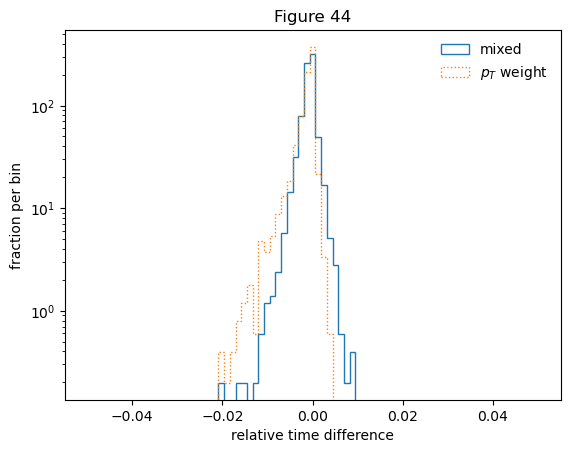

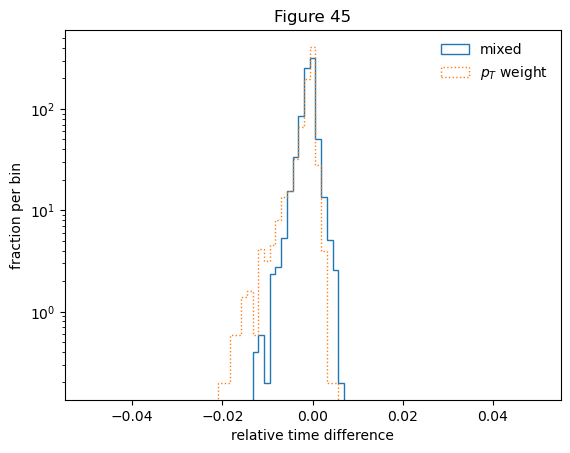

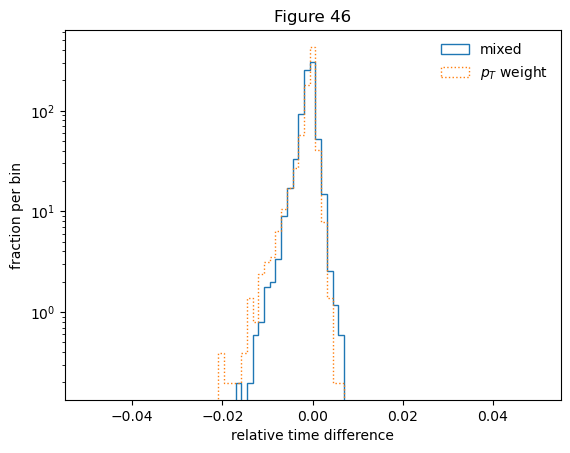

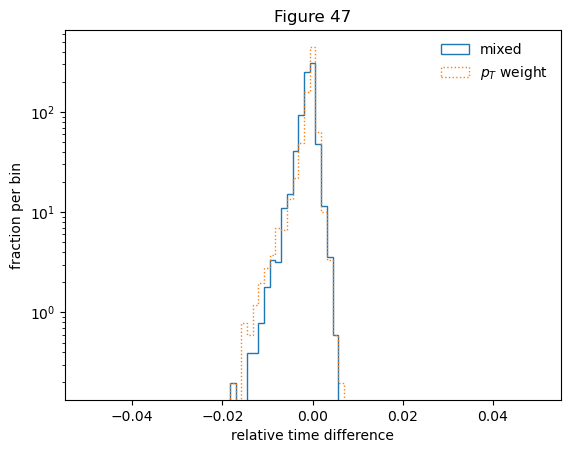

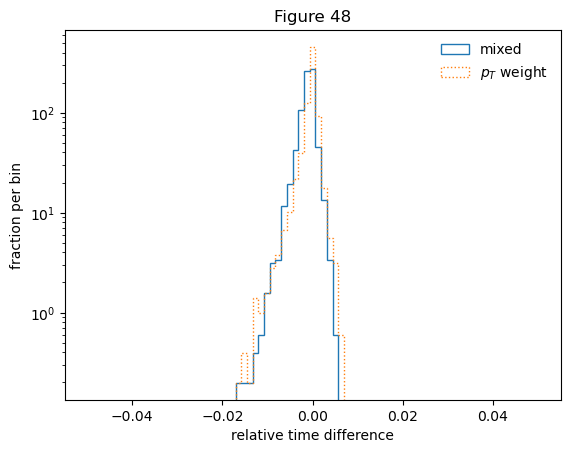

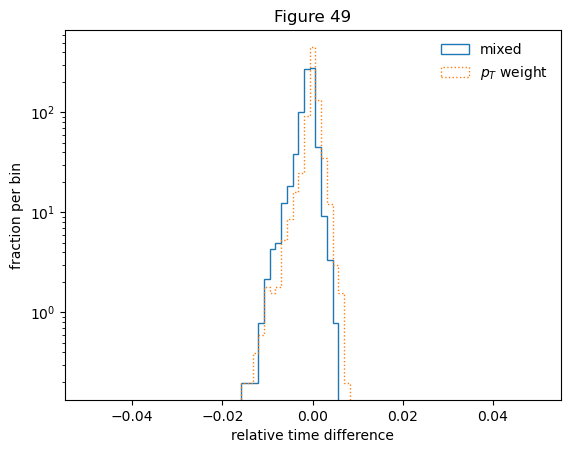

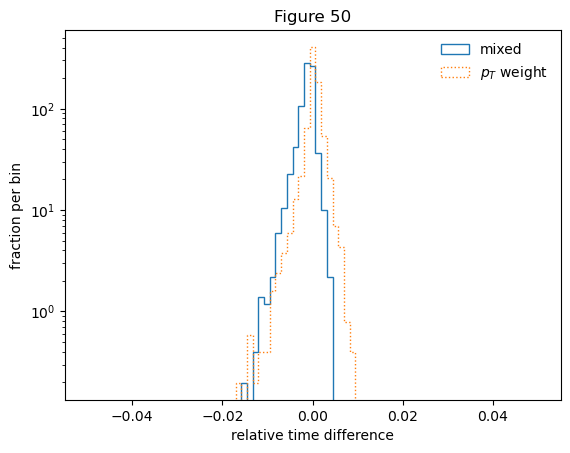

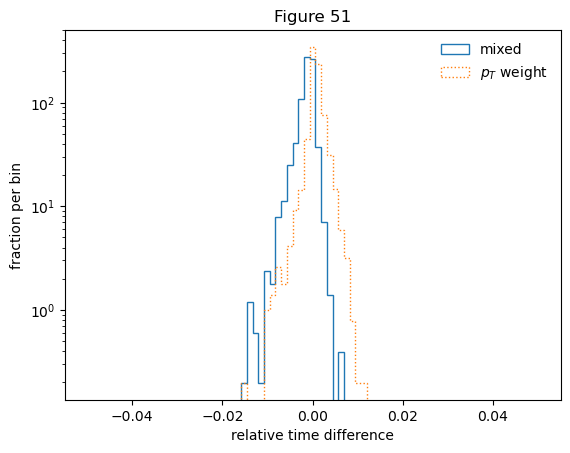

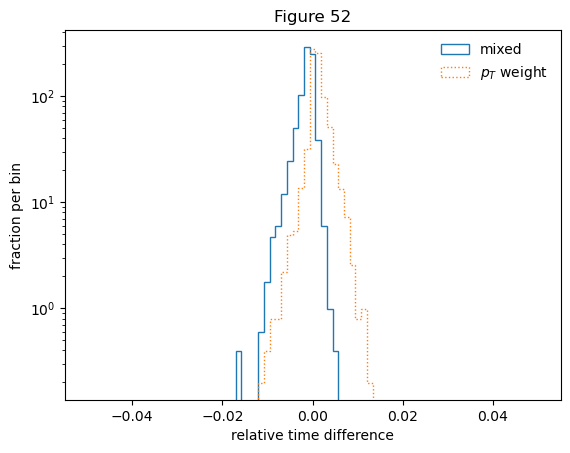

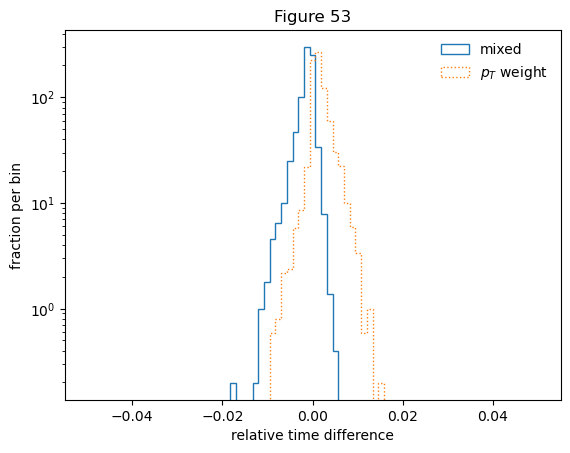

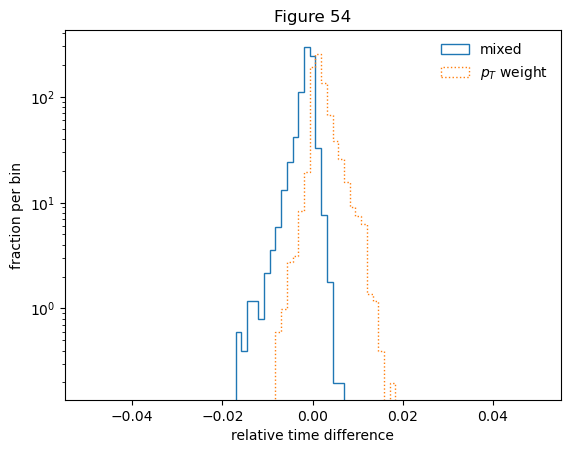

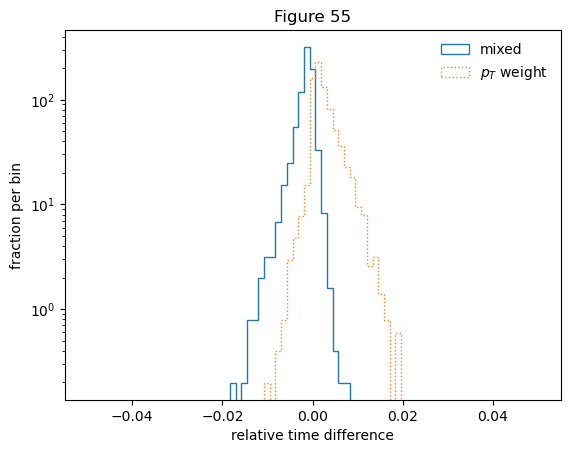

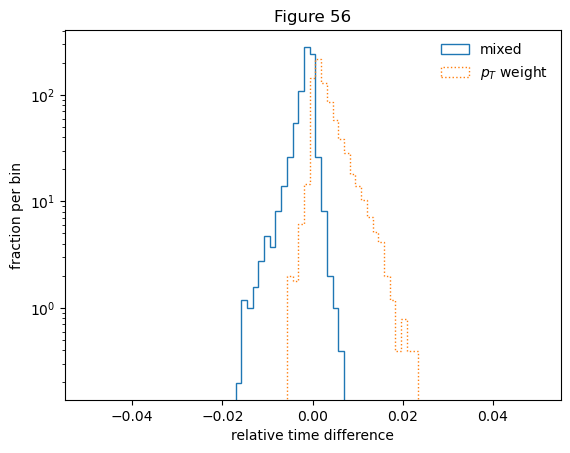

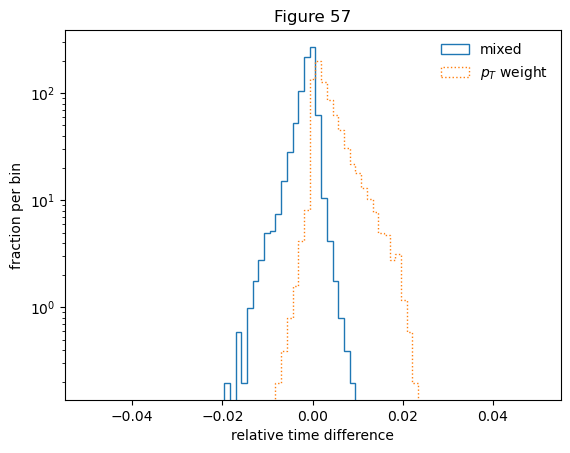

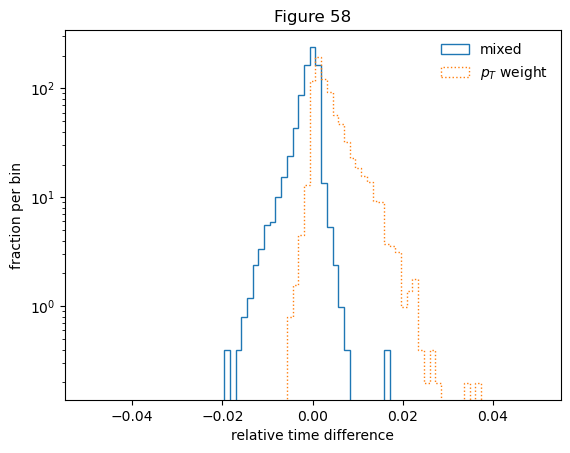

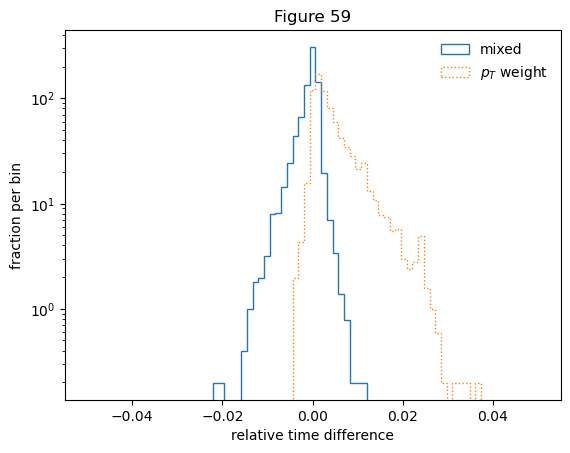

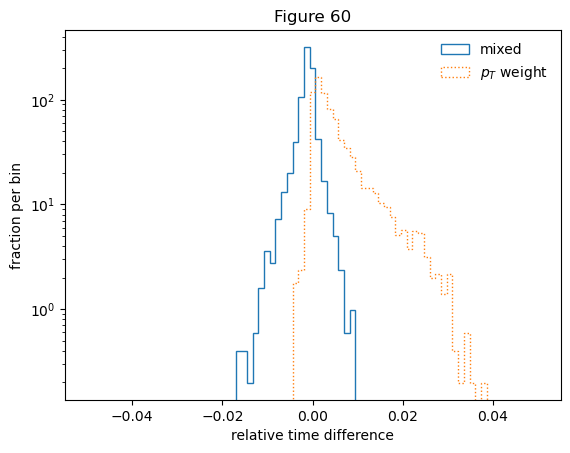

In [23]:
NNpred_list = []
pTpred_list = []

for i, eta_path in enumerate(unseenetaM_path_list):
    test_z = unseen_input_dict["input"+eta_path][:,:,0]
    test_X = unseen_input_dict["input"+eta_path][:,:,1:]
    test_Y = unseen_label_dict["label"+eta_path]

    preds_unseen_mixed = mixed_efn.predict([test_z,test_X],batch_size=200)
    difference = preds_unseen_mixed/test_Y - 1
    residuals = unseen_rtd_dict["rtd"+eta_path]

    NNpred_list.append(difference)
    pTpred_list.append(residuals)

    plt.figure()
    plt.hist(difference,bins=np.linspace(-0.05,0.05,80),density=True,histtype="step",label="mixed")
    plt.hist(residuals,bins=np.linspace(-0.05,0.05,80),density=True,histtype="step",label="$p_T$ weight",ls=":")
    plt.yscale("log")
    plt.xlabel("relative time difference")
    plt.ylabel("fraction per bin")
    plt.title(f'Figure {i}')
    plt.legend(frameon=False)
plt.show()


In [24]:
np.save('NNpred_list_org_unnor_etaM_3.npy', NNpred_list)
np.save('pTpred_list_org_unnor_etaM_3.npy', pTpred_list)